# ST455 HW7 - Neural FQI Algorithm on CartPole

The purpose of this project is to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation.

In [1]:
# Algo
import gymnasium as gym
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from copy import deepcopy

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Animation
import matplotlib.animation
from IPython.display import HTML

# Set seed
seed = 1

In [2]:
env = gym.make('CartPole-v1')
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


## Step 1: Generate an offline dataset

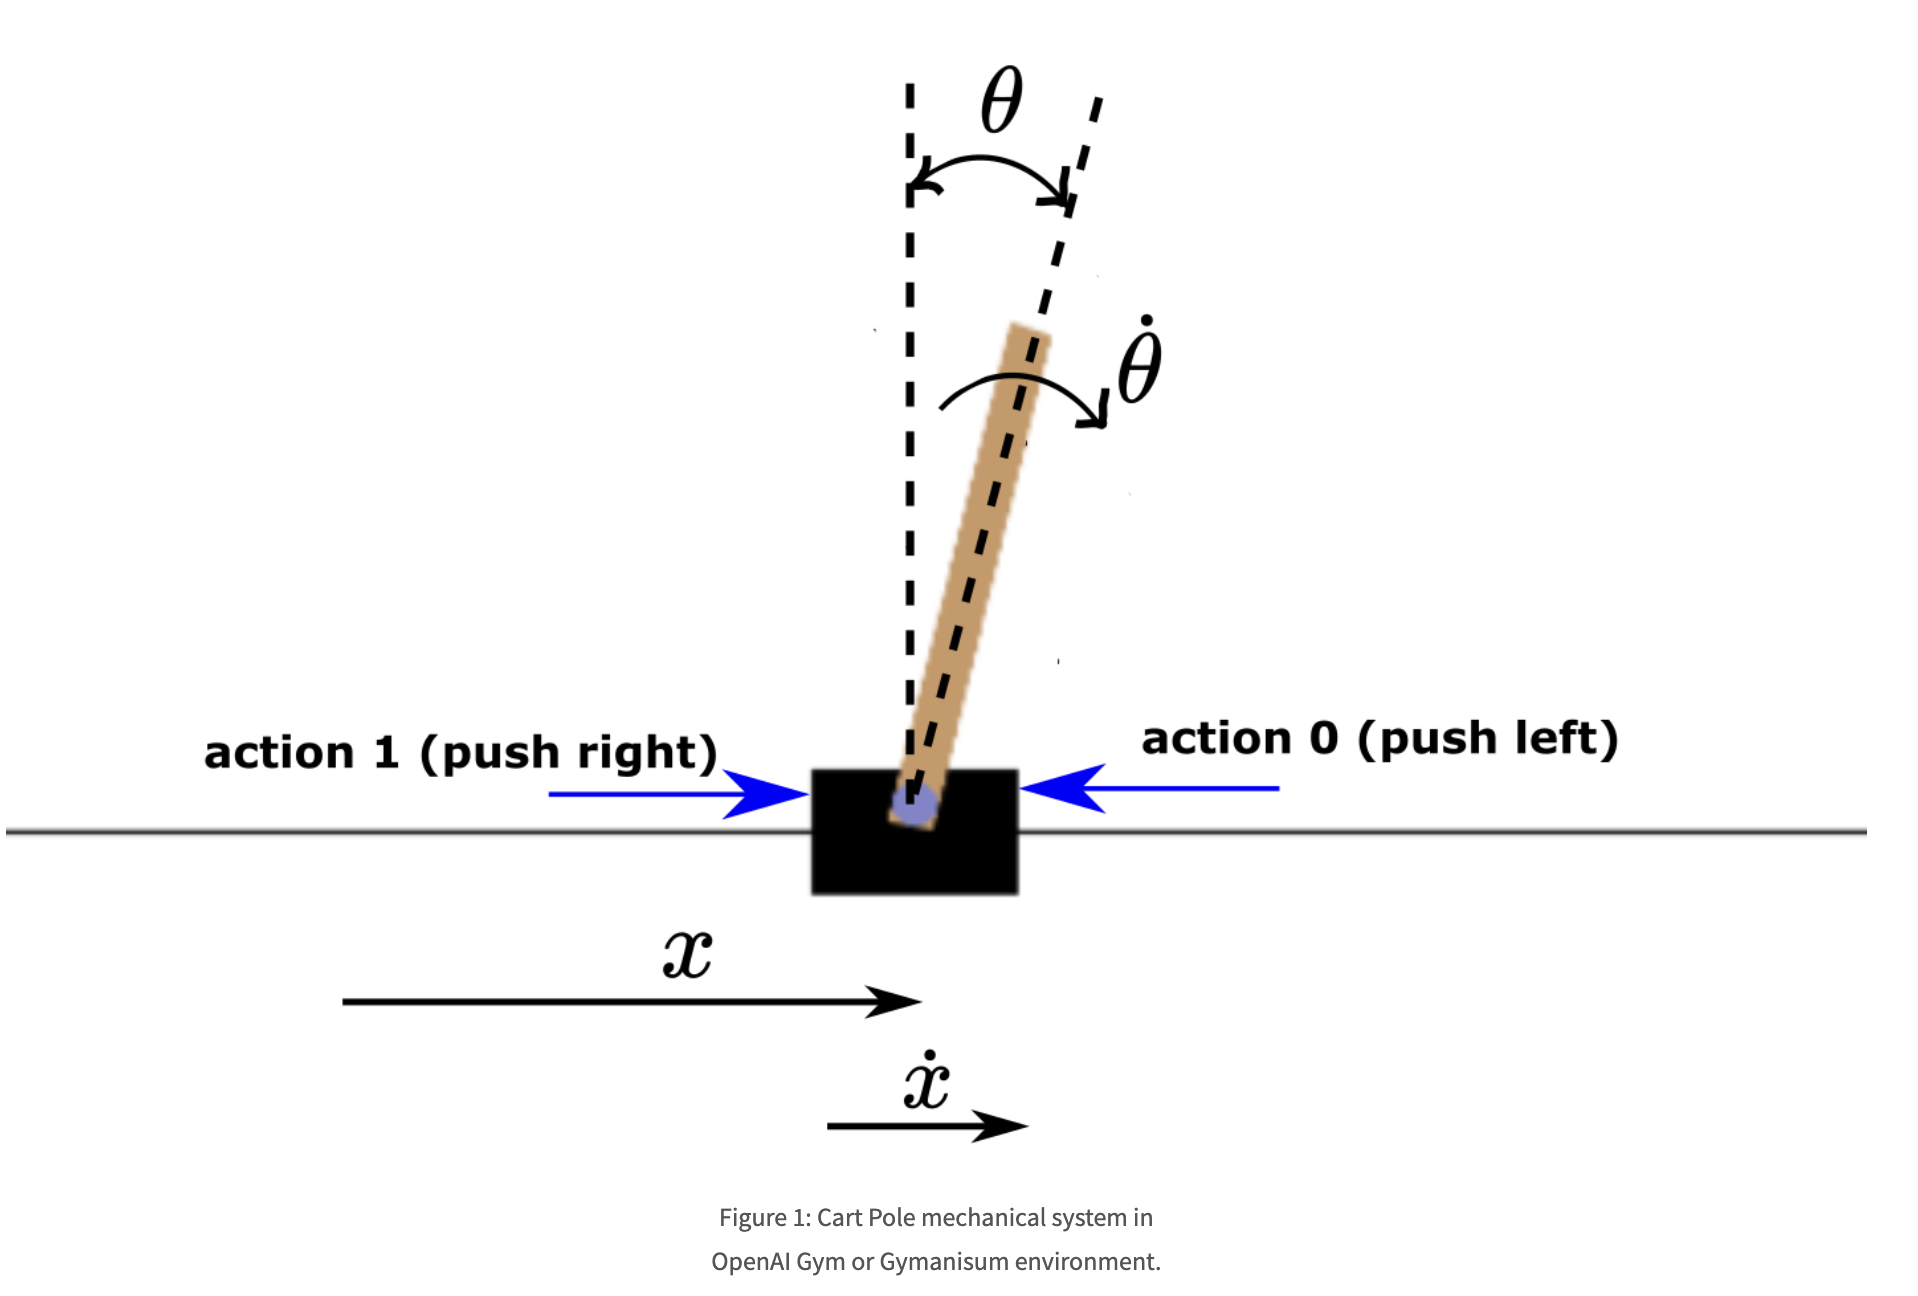

In [20]:
from IPython.display import Image

Image(filename='2.png')
# Reference: https://aleksandarhaber.com/cart-pole-control-environment-in-openai-gym-gymnasium-introduction-to-openai-gym/

In [3]:
def action(angle):
    if np.random.binomial(1, 0.5):
        if angle < 0:
            return 0 # push left according to the graph above
        else:
            return 1 # push right according to the graph above
    else:
        return np.random.binomial(1, 0.5) # Uniform Random Policy

In [4]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
np.random.seed(seed)
env.reset(seed=seed)

episodes = 100
data = np.array([])
for i in range(episodes):
    obs = env.reset()
    obs = obs[0]
    done = False
    rewards = 0.0
    while not done and rewards < 500:
        s = obs
        env.render()
        a = action(obs[2])
        obs, r, done, info, _ = env.step(a)

        data = np.append(data, {'state': s, 'action': a, 'reward': r, 'next': obs, 'is_done': done})

        rewards += r
    print('Episode:', i, 'Rewards:', rewards)
    print('Observations:', obs)

# Reference: seminar1 - Part1

print(data.shape) # (4400,)

Episode: 0 Rewards: 41.0
Observations: [-0.2375806  -1.3543879   0.22088762  1.6524197 ]
Episode: 1 Rewards: 43.0
Observations: [ 0.16790192  0.14941135 -0.21139108 -0.32988834]
Episode: 2 Rewards: 103.0
Observations: [ 0.7682711   1.7516848  -0.23884355 -1.952966  ]
Episode: 3 Rewards: 56.0
Observations: [ 0.19296758  1.1487963  -0.22640686 -1.5442502 ]
Episode: 4 Rewards: 51.0
Observations: [ 0.46969983  1.2999805  -0.22880977 -1.0576887 ]
Episode: 5 Rewards: 33.0
Observations: [-0.19661513 -0.5496584   0.21820414  0.57702726]
Episode: 6 Rewards: 24.0
Observations: [-0.16726387  0.03340306  0.21386172  0.26704174]
Episode: 7 Rewards: 23.0
Observations: [-0.10365133 -0.56744295  0.22381796  1.1608334 ]
Episode: 8 Rewards: 59.0
Observations: [-0.03141681  0.9898581  -0.22470552 -1.796851  ]
Episode: 9 Rewards: 18.0
Observations: [ 0.20164794  1.208991   -0.2468944  -1.8954419 ]
Episode: 10 Rewards: 82.0
Observations: [-0.7490424   1.2195605  -0.22092867 -2.8398504 ]
Episode: 11 Rewards

Episode: 95 Rewards: 66.0
Observations: [ 0.28567392  0.00345729 -0.21433313 -0.11785002]
Episode: 96 Rewards: 19.0
Observations: [ 0.11138636  0.55097806 -0.21214168 -1.007352  ]
Episode: 97 Rewards: 40.0
Observations: [-0.29610747 -1.860112    0.2128569   2.0105648 ]
Episode: 98 Rewards: 84.0
Observations: [-0.9834197  -1.9002539   0.22287177  1.7451794 ]
Episode: 99 Rewards: 21.0
Observations: [-0.05430797 -0.94374096  0.211718    1.7907187 ]
(4400,)


## Step 2: Fitted Q-iteration

In [5]:
gammas = [0.95, 0.99, 1]

# Separate left and right
X_l = np.array([row['state'] for row in data if row['action'] == 0])
X_r = np.array([row['state'] for row in data if row['action'] == 1])

print(X_l.shape, X_r.shape)

(2210, 4) (2190, 4)


In [6]:
all_models = {}
for gamma in gammas:
    models = []
    print(f"Training models with gamma = {gamma}")

    for i in range(20):
        if i == 0:
            l_model = MLPRegressor(max_iter=500)
            r_model = MLPRegressor(max_iter=500) # Define separate models for l and r according to p11 in lecture 5
        else:
            l_model = deepcopy(models[i-1][0])
            r_model = deepcopy(models[i-1][1])
        
        # Initialize y_l and y_r
        y_l = np.zeros(X_l.shape[0])
        y_r = np.zeros(X_r.shape[0])
        
        # Use counters to align y_l and y_r with X_l and X_r
        l_counter = 0
        r_counter = 0
        
        for row in data:    
            im_reward = row['reward']

            if i == 0 or row['is_done']: 
                next_reward = 0
            else:
                q_next_l = l_model.predict(row['next'].reshape(1, -1))
                q_next_r = r_model.predict(row['next'].reshape(1, -1))
                next_reward = gamma * max(q_next_l, q_next_r)

            if row['action'] == 0:  # l
                y_l[l_counter] = im_reward + next_reward
                l_counter += 1
            else:  # r
                y_r[r_counter] = im_reward + next_reward
                r_counter += 1

        l_model.fit(X_l, y_l)
        r_model.fit(X_r, y_r)

        print(f"Finished training iteration {i+1}")
        models.append([l_model, r_model])
    
    all_models[gamma] = models


# Note: A warning is displayed—Stochastic Optimizer: Maximum iterations (500) reached, and the optimization has not yet converged.
# If want to improve the model's performance, could increase the number of iterations to, for example, 2000.
# However, since this is the setting requested in the question, ignore this warning and continue for now.

Training models with gamma = 0.95
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3
Finished training iteration 4
Finished training iteration 5
Finished training iteration 6


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 7


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20
Training models with gamma = 0.99
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3
Finished training iteration 4


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 5


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 6
Finished training iteration 7


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20
Training models with gamma = 1
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3
Finished training iteration 4


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 5


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 6


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 7


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20


/Users/Ireneee-/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Step 3: Policy evaluation

In [7]:
# Choose the action which maximises the Q-function approximator
def fqi_policy(state, l_model, r_model):
    
    if l_model.predict(state) > r_model.predict(state):
        return 0 # l
    else:
        return 1 # r

In [8]:
np.random.seed(seed)
env = gym.make('CartPole-v1', render_mode="rgb_array")
results = []

for gamma, models in all_models.items():
    print(f"Evaluating gamma = {gamma}")
    
    for i in range(len(models)):
        env.reset(seed=seed)
        episodes = 1000
        rewards_mc = []
        l_model, r_model = models[i][0], models[i][1] 
        for j in range(episodes):
            obs = env.reset()
            obs = obs[0]
            done = False
            rewards = 0.0
            while not done and rewards < 500: # The value of 500 is chosen based on the setting in the Gym package
                a = fqi_policy(obs.reshape(1, -1), l_model, r_model)
                obs, r, done, info, _ = env.step(a)
                rewards += r

            rewards_mc.append(rewards)
        
        avg_reward = np.mean(rewards_mc) # Avg reward, which is the output we want
        result = [gamma, i+1, avg_reward]
        
        results.append(result)
        
# Reference: seminar1 - Part1
        
results_df = pd.DataFrame(results, columns=['gamma', 'fqi_iteration', 'avg_reward'])

print(results_df)


Evaluating gamma = 0.95
Evaluating gamma = 0.99
Evaluating gamma = 1
    gamma  fqi_iteration  avg_reward
0    0.95              1      28.257
1    0.95              2      16.793
2    0.95              3     202.646
3    0.95              4     253.340
4    0.95              5     248.766
5    0.95              6     259.672
6    0.95              7     252.364
7    0.95              8     256.978
8    0.95              9     291.334
9    0.95             10     463.896
10   0.95             11     200.682
11   0.95             12     258.650
12   0.95             13     355.423
13   0.95             14     324.216
14   0.95             15     206.959
15   0.95             16     287.988
16   0.95             17     337.262
17   0.95             18     173.430
18   0.95             19     250.047
19   0.95             20     223.277
20   0.99              1      20.600
21   0.99              2      27.594
22   0.99              3     176.791
23   0.99              4     216.352
24   0

## Visualization:

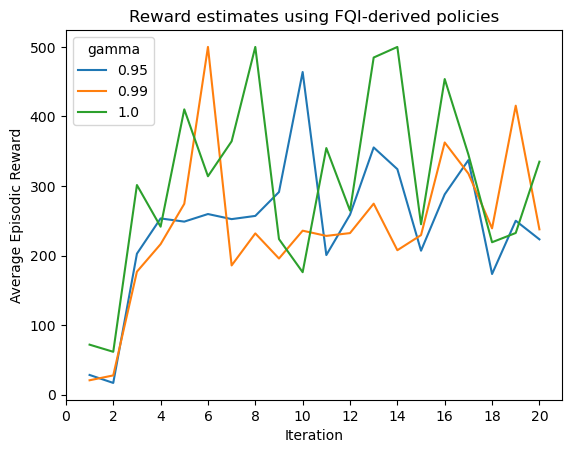

In [9]:
sns.lineplot(x='fqi_iteration', y='avg_reward', hue='gamma', data=results_df, palette='tab10')
plt.title("Reward estimates using FQI-derived policies")
plt.xlabel("Iteration")
plt.ylabel("Average Episodic Reward")

plt.gca().set_xticks(np.arange(0, 21, 2))

plt.show()

This graph displays the average reward using neural FQI-derived policies with different discount factors (gamma). There are three lines on the graph, each corresponding to a different discount factor value: 0.95 (blue), 0.99 (orange), and 1.0 (green). The graph could be interpreted via three main aspects:

1. **Initial Growth**: In the early stages of iterations (approximately the first 5 iterations), all lines show a rapid increase in rewards. At this stage, all policies learn quickly and improve their performance in the initial phase.

2. **Later-Term Fluctuations**: During the middle phase (approximately from iteration 5 to 15), the lines all show significant fluctuations. This might due to the policies still balancing between exploration and exploitation.

3. **Gamma Effect**:
   - **Gamma = 0.95**: This line shows relatively lower reward values, with significant fluctuations since tenth iteration, indicating that a lower discount factor might lead the policy to focus more on short-term rewards, resulting in instability in long-term performance.
   - **Gamma = 0.99**: It shows similar reward values in the later stages as the gamma = 0.95 line, and with significant fluctuations as well. This suggests that a higher discount factor helps the policy focus on long-term rewards more, but might also have a high level of instability.
   - **Gamma = 1.0**: This line shows the highest reward values overall in the later stages but also with significant fluctuations, similar to the other two lines. This indicates that when the discount factor is 1, the policy fully focuses on long-term rewards, which might lead to overly conservative or aggressive behavior, increasing volatility.


### **Possible Ways to Improve the Algorithm Performance**
1. **Increase Dataset Size**

A **larger and more diverse dataset** (by collecting more episodes) can help reduce overfitting and improve stability.

2. **Regularization for MLPRegressor**

Increasing `alpha` (L2 regularization) in `MLPRegressor` can prevent overfitting (default alpha is 0.0001). This would reduce sudden fluctuations in Q-values.

3. **Increase Training Iterations or Reduce Learning Rate**

More training iterations (but with proper early stopping) can help smooth the learning curve. (And also ensures convergence) A lower learning rate (default learning rate is 0.001) helps avoid large Q-value fluctuations.
```python
MLPRegressor(max_iter=1000, learning_rate_init=0.0001)
```

4. **Use Target Networks (Similar to DQN)**

Instead of updating Q-values based on the latest model, **use a target network** that updates slowly to stabilize learning.




## Further Exploration - 1: Animation

To better understand the results we obtained, we will use the animation to simulate the outcomes. Choose gamma value of 1, with fqi_iteration_target = 13, to visualize the animation.

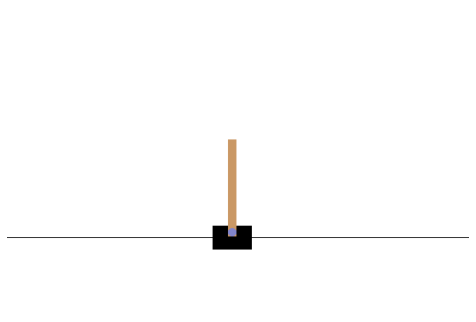

In [10]:
# Set parameters for the desired model
gamma_target = 1
fqi_iteration_target = 13

l_model, r_model = all_models[gamma_target][fqi_iteration_target - 1]

# Initialize environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=seed)

frames = []
obs = env.reset()[0]
total_reward = 0
done = False

while not done and total_reward < 500:
    action = fqi_policy(obs.reshape(1, -1), l_model, r_model)

    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    frames.append(env.render())

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(ani.to_jshtml())

# Reference: Seminar 5

The animation above is very ideal, showing a very stable cartpole.

## Further Exploration - 2: Max_iter

As mentioned earlier, we aim to increase the number of iterations to ensure convergence and improve the results in this part.

In [11]:
all_models = {}
for gamma in gammas:
    models = []
    print(f"Training models with gamma = {gamma}")

    for i in range(20):
        if i == 0:
            l_model = MLPRegressor(max_iter=1000) # Change from 500 to 1000
            r_model = MLPRegressor(max_iter=1000) # Change from 500 to 1000
        else:
            l_model = deepcopy(models[i-1][0])
            r_model = deepcopy(models[i-1][1])
        
        # Initialize y_l and y_r
        y_l = np.zeros(X_l.shape[0])
        y_r = np.zeros(X_r.shape[0])
        
        # Use counters to align y_l and y_r with X_l and X_r
        l_counter = 0
        r_counter = 0
        
        for row in data:    
            im_reward = row['reward']

            if i == 0 or row['is_done']: 
                next_reward = 0
            else:
                q_next_l = l_model.predict(row['next'].reshape(1, -1))
                q_next_r = r_model.predict(row['next'].reshape(1, -1))
                next_reward = gamma * max(q_next_l, q_next_r)

            if row['action'] == 0:  # l
                y_l[l_counter] = im_reward + next_reward
                l_counter += 1
            else:  # r
                y_r[r_counter] = im_reward + next_reward
                r_counter += 1

        l_model.fit(X_l, y_l)
        r_model.fit(X_r, y_r)

        print(f"Finished training iteration {i+1}")
        models.append([l_model, r_model])
    
    all_models[gamma] = models


Training models with gamma = 0.95
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3
Finished training iteration 4
Finished training iteration 5
Finished training iteration 6
Finished training iteration 7
Finished training iteration 8
Finished training iteration 9
Finished training iteration 10
Finished training iteration 11
Finished training iteration 12
Finished training iteration 13
Finished training iteration 14
Finished training iteration 15
Finished training iteration 16
Finished training iteration 17
Finished training iteration 18
Finished training iteration 19
Finished training iteration 20
Training models with gamma = 0.99
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3
Finished training iteration 4
Finished training iteration 5
Finished training iteration 6
Finished training iteration 7
Finished training iteration 8
Finished training iteration 9
Finished training iteration 10
Finished training it

We can see that there are no warnings here, indicating that the optimizers have successfully converged, which is ideal.

In [12]:
# Choose the action which maximises the Q-function approximator
def fqi_policy(state, l_model, r_model):
    
    if l_model.predict(state) > r_model.predict(state):
        return 0 # l
    else:
        return 1 # r

In [13]:
np.random.seed(seed)
env = gym.make('CartPole-v1', render_mode="rgb_array")
results = []

for gamma, models in all_models.items():
    print(f"Evaluating gamma = {gamma}")
    
    for i in range(len(models)):
        env.reset(seed=seed)
        episodes = 1000
        rewards_mc = []
        l_model, r_model = models[i][0], models[i][1] 
        for j in range(episodes):
            obs = env.reset()
            obs = obs[0]
            done = False
            rewards = 0.0
            while not done and rewards < 500: # The value of 500 is chosen based on the setting in the Gym package
                a = fqi_policy(obs.reshape(1, -1), l_model, r_model)
                obs, r, done, info, _ = env.step(a)
                rewards += r

            rewards_mc.append(rewards)
        
        avg_reward = np.mean(rewards_mc) # Avg reward, which is the output we want
        result = [gamma, i+1, avg_reward]
        
        results.append(result)
        
# Reference: seminar1 - Part1
        
results_df = pd.DataFrame(results, columns=['gamma', 'fqi_iteration', 'avg_reward'])

print(results_df)


Evaluating gamma = 0.95
Evaluating gamma = 0.99
Evaluating gamma = 1
    gamma  fqi_iteration  avg_reward
0    0.95              1      94.921
1    0.95              2      50.998
2    0.95              3      16.431
3    0.95              4     235.079
4    0.95              5     194.418
5    0.95              6     318.184
6    0.95              7     266.121
7    0.95              8     200.586
8    0.95              9     442.543
9    0.95             10     198.097
10   0.95             11     191.574
11   0.95             12     500.000
12   0.95             13     226.617
13   0.95             14     500.000
14   0.95             15     204.484
15   0.95             16     500.000
16   0.95             17     497.343
17   0.95             18     156.158
18   0.95             19     184.304
19   0.95             20     161.023
20   0.99              1      73.892
21   0.99              2      31.876
22   0.99              3      28.383
23   0.99              4     149.532
24   0

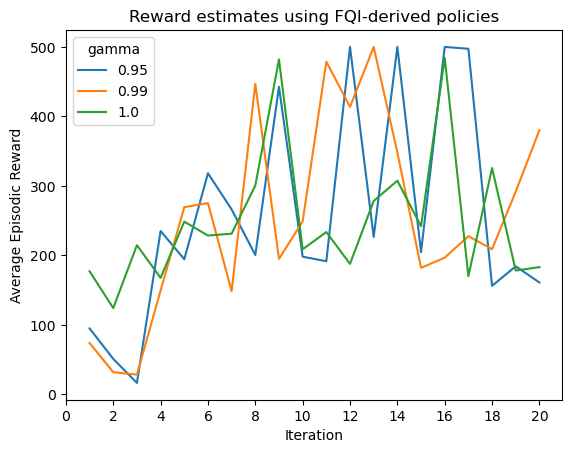

In [14]:
sns.lineplot(x='fqi_iteration', y='avg_reward', hue='gamma', data=results_df, palette='tab10')
plt.title("Reward estimates using FQI-derived policies")
plt.xlabel("Iteration")
plt.ylabel("Average Episodic Reward")

plt.gca().set_xticks(np.arange(0, 21, 2))

plt.show()

Compared to the previous graph, we can see that this new graph has a slower increase in the first few iterations, a relatively higher reward while larger fluctuations across all gamma values thereafter. These observations are occured might because of the following reasons:

**1. Slower Increase in the First Few Iterations**  
- **More gradual learning**: Increasing iterations allows for more optimization steps, meaning that early updates might be smaller as the optimizer carefully refines weights.  
- **Regularization effects**: Since L2 regularization (alpha) exists in our model, a higher iteration count could make early updates more controlled, leading to a slower initial reward increase.  

**2. Higher Reward Thereafter**  
- **Better convergence**: More training iterations enable the model to fine-tune weights more, leading to better Q-value approximation.  
- **Avoiding underfitting**: Since 500 iterations were insufficient and its optimizer was not converged, the model might not have fully learned optimal value functions. With 1000 iterations, the model has more time to generalize and improve rewards.  

**3. Larger Fluctuations Across Gamma Values**  
- **Increased sensitivity to discount factor (γ)**: With more training iterations, the model’s learned Q-values may become more sensitive to γ, leading to larger variations in performance.  
- **Overfitting risk**: If the model learns too much from the training data without generalizing well, Q-values might fluctuate more between training episodes.  
- **Adaptive learning dynamics**: More iterations allow for more complex patterns to emerge, which could introduce variance in learning stability across different γ values.